# Loading libraries

In [1]:
import ZonalStatsFunctions as zsf
import xarray as xr
import numpy as np
from dask.distributed import Client
import scipy.stats as ss

#Useful for plotting figures, including maps
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
import cmocean as cm
from glob import glob

# Defining seasons and sector names

In [2]:
#Defining sea ice seasons
SI_seasons = ['advance', 'retreat', 'duration']

#Defining sector names in order
sectorNames = ['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific']

# Loading clipped model data

In [4]:
#Clipped data location
out_file = sorted(glob(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in out_file if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS[f'{sec}_{sea}'] = clipped_SIS[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

# Loading Antartica clipped shapes

In [4]:
#Location of Antartica files
in_file = r'/g/data/v45/la6889/GIS_DataBase/Antarctica_MEASO'

#Creating an empty dictionary to load data
Antarctica = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(in_file) if os.path.isfile(os.path.join(in_file, f))])

names = []
[names.append(f'{sec}') for sec in sectorNames]

#Opening all files in a dictionary
for file, name in zip(files, sorted(names)):
    Antarctica[f"{name}"] = xr.open_dataarray(os.path.join(in_file, file), autoclose = True)

# Plotting climatologies

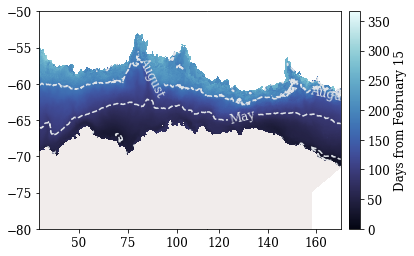

In [ ]:
climEI = clipped_SIS['East Indian_advance'].sel(time = slice('1979', '2008')).mean('time')
climCI = clipped_SIS['Central Indian_advance'].sel(time = slice('1979', '2008')).mean('time')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12


fig = plt.figure()
ax = fig.add_subplot(121)
c = climCI.plot(ax= ax, cmap = cm.cm.ice, add_colorbar = False, vmin = 0, vmax = 366)
Antarctica['Central Indian'].plot.pcolormesh(cmap = cm.cm.balance, add_colorbar = False, ax = ax)
marCI = climCI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [29], colors = '#dfe3e8', ax = ax, linestyles = 'dashed')
ax.clabel(marCI, marCI.levels, inline = True, fmt = "March", fontsize = 12)
mayCI = climCI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [90], colors = '#dfe3e8', ax = ax, linestyles = 'dashed')
ax.clabel(mayEI, mayEI.levels, inline = True, fmt = "May", fontsize = 12)
augCI = climCI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [182], colors = '#dfe3e8', ax = ax, linestyles = 'dashed')
ax.clabel(augCI, augCI.levels, inline = True, fmt = "August", fontsize = 12)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([-80, -50])
ax.set_title('')
ax.spines['right'].set_visible(False)

ax1 = fig.add_subplot(122)
c1 = climEI.plot(ax= ax1, cmap = cm.cm.ice, add_colorbar = False, vmin = 0, vmax = 366)
Antarctica['East Indian'].plot.pcolormesh(cmap = cm.cm.balance, add_colorbar = False, ax = ax1)
marEI = climEI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [29], colors = '#dfe3e8', ax = ax1, linestyles = 'dashed')
ax1.clabel(marEI, marEI.levels, inline = True, fmt = "March", fontsize = 12)
mayEI = climEI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [90], colors = '#dfe3e8', ax = ax1, linestyles = 'dashed')
ax1.clabel(mayEI, mayEI.levels, inline = True, fmt = "May", fontsize = 12)
augEI = climEI.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [182], colors = '#dfe3e8', ax = ax1, linestyles = 'dashed')
ax1.clabel(augEI, augEI.levels, inline = True, fmt = "August", fontsize = 12)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_ticks([])
ax1.set_ylim([-80, -50])
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('')

cb = plt.colorbar(c1)
cb.set_label('Days from February 15')

plt.subplots_adjust(wspace = 0)
plt.savefig('IndianO_clim.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Plotting yearly trends

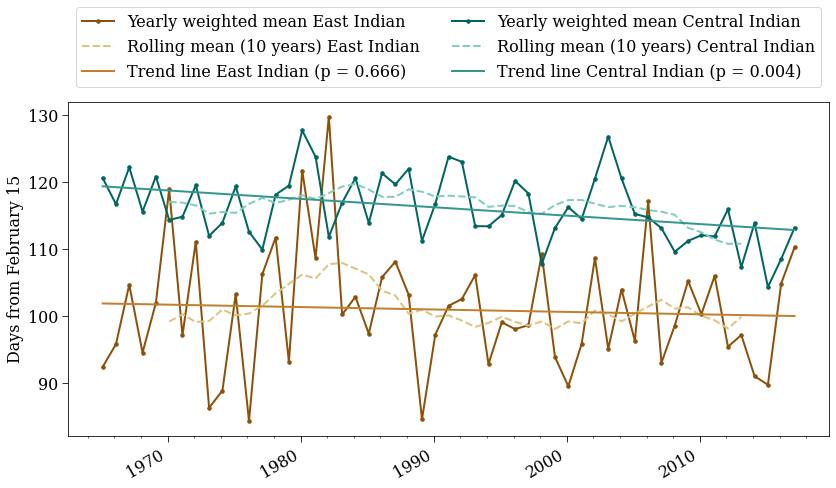

In [84]:
areaEI = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/MEASOsectors/area_per_pixel_01deg_East Indian_mod.nc')
areaCI = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/MEASOsectors/area_per_pixel_01deg_Central Indian_mod.nc')
areaCI = areaCI.fillna(0)
areaEI = areaEI.fillna(0)

EI_w = clipped_SIS['East Indian_advance'].weighted(areaEI).mean(('xt_ocean', 'yt_ocean'))
CI_w = clipped_SIS['Central Indian_advance'].weighted(areaCI).mean(('xt_ocean', 'yt_ocean'))

slopeEI, interceptEI, rEI, pEI, seEI = ss.linregress(EI_w.time.dt.year.values, EI_w.values)
slopeCI, interceptCI, rCI, pCI, seCI = ss.linregress(CI_w.time.dt.year.values, CI_w.values)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize = (17.5, 6))
ax = fig.add_subplot(111)
EI_w.plot(ax = ax, linewidth = 2, marker = 'o', markersize = 3.5, color = '#8c510a', label = 'Yearly weighted mean East Indian')
#Calculate the rolling decadal mean per sector and season
EI_w.rolling(time = 10, center = True).mean().dropna('time').plot(ax = ax, color = '#dfc27d', linestyle = '--', linewidth = 2,
                                                                  label = 'Rolling mean (10 years) East Indian')
plt.plot(EI_w.time, interceptEI+(slopeEI*EI_w.time.dt.year.values), 
         label = f'Trend line East Indian (p = {round(pEI, 3)})', color = '#bf812d', linewidth = 2)

CI_w.plot(ax = ax, linewidth = 2, marker = 'o', markersize = 3.5, color = '#01665e', label = 'Yearly weighted mean Central Indian')
CI_w.rolling(time = 10, center = True).mean().dropna('time').plot(ax = ax, color = '#80cdc1', linestyle = '--', linewidth = 2,
                                                                  label = 'Rolling mean (10 years) Central Indian')
plt.plot(CI_w.time, interceptCI+(slopeCI*CI_w.time.dt.year.values), 
         label = f'Trend line Central Indian (p = {round(pCI, 3)})', color = '#35978f', linewidth = 2)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.height * 0.8, box.width])

# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol = 2)

# #Remove x axis label
ax.set_xlabel('')
ax.set_ylabel('Days from February 15')
ax.set_title('')
# #Increasing the size of the x and y axes ticks
ax.tick_params(length = 6)
# For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
plt.savefig('Indian_year.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Print trends and std errors

In [90]:
print('EI', round(slopeEI*10,2), round(seEI*10,2))
print('CI', round(slopeCI*10,2), round(seCI*10,2))

EI -0.36 0.83
CI -1.25 0.42


# Loading clipped observational data

In [5]:
#Getting a list of nc files inside the folder containing the clipped data
in_files = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS_obs = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in in_files if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS_obs[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS_obs[f'{sec}_{sea}'] = clipped_SIS_obs[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

# Clip area to match observations and model data

In [7]:
#Load area per pixel for Southern Ocean
area = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg.nc')

#Initialise dictionary to store data
clipped_area = {}

#Extract weights for each sector
for sec in sectorNames:
    mod = []
    obs = []
    for sea in SI_seasons:
        mod_data = clipped_SIS[f'{sec}_{sea}'].sum('time', skipna = True, min_count = 1)
        obs_data = clipped_SIS_obs[f'{sec}_{sea}'].sum('time', skipna = True, min_count = 1)
        m = area.where(~np.isnan(mod_data))
        m.name = sea
        o = area.where(~np.isnan(obs_data))
        o.name = sea
        mod.append(m)
        obs.append(o)
        clipped_area[f'{sec}_mod'] = xr.merge(mod)
        clipped_area[f'{sec}_obs'] = xr.merge(obs)

In [8]:
data_pdf = {}
for sec in sectorNames:
    keys = [key for key in clipped_SIS.keys() if sec in key]
    keys_weights = [key for key in clipped_area.keys() if sec in key]
    mod = []
    obs = []
    for sea in SI_seasons[:-1]:
        sea_key = [key for key in keys if sea in key]
        mod.append(clipped_SIS[sea_key[0]])
        obs.append(clipped_SIS_obs[sea_key[0]])
    data_pdf[f'{sec}_mod'] = xr.merge(mod)
    data_pdf[f'{sec}_obs'] = xr.merge(obs)

# Probability density functions

In [10]:
def pdfCalcs(obs, mod, bins, weights_obs, weights_mod):
    #Stacking data and apply
    pdf_mod = {}
    pdf_obs = {}
    for sea in SI_seasons[0:2]:        
        #Models
        mod_int = mod[sea].sel(time = slice('1979', '2017'))
        s_mod = mod_int.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_mod = ~np.isnan(s_mod)
        #Save masked data
        masked_mod = s_mod[mask_mod]
        #Get weights for model data
        w_mod = weights_mod[sea].broadcast_like(mod_int)
        s_weight = w_mod.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        weight_model = s_weight[mask_mod]
        
        #Observations
        obs_int = obs[sea].sel(time = slice('1979', '2017'))
        s_obs = obs_int.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_obs = ~np.isnan(s_obs)
        masked_obs = s_obs[mask_obs]
        #Get weights for observations
        w_obs = weights_obs[sea].broadcast_like(obs_int)
        m_weight = w_obs.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        weight_obs = m_weight[mask_obs]      
        
        #Calculating KDEs
        #Models
        kde_mod = ss.gaussian_kde(masked_mod, weights = weight_model)
        pdf_mod[f'{sea}'] = kde_mod(bins)
        #Observations
        kde_obs = ss.gaussian_kde(masked_obs, weights = weight_obs)
        pdf_obs[f'{sea}'] = kde_obs(bins)
        
    return pdf_obs, pdf_mod

In [21]:
obs_EI, mod_EI = pdfCalcs(obs = data_pdf['East Indian_obs'], 
         mod = data_pdf['East Indian_mod'], 
         bins = np.arange(0, 367),
         weights_obs = clipped_area['East Indian_obs'],
         weights_mod = clipped_area['East Indian_mod'])

In [22]:
obs_CI, mod_CI = pdfCalcs(obs = data_pdf['Central Indian_obs'], 
         mod = data_pdf['Central Indian_mod'], 
         bins = np.arange(0, 367),
         weights_obs = clipped_area['Central Indian_obs'],
         weights_mod = clipped_area['Central Indian_mod'])

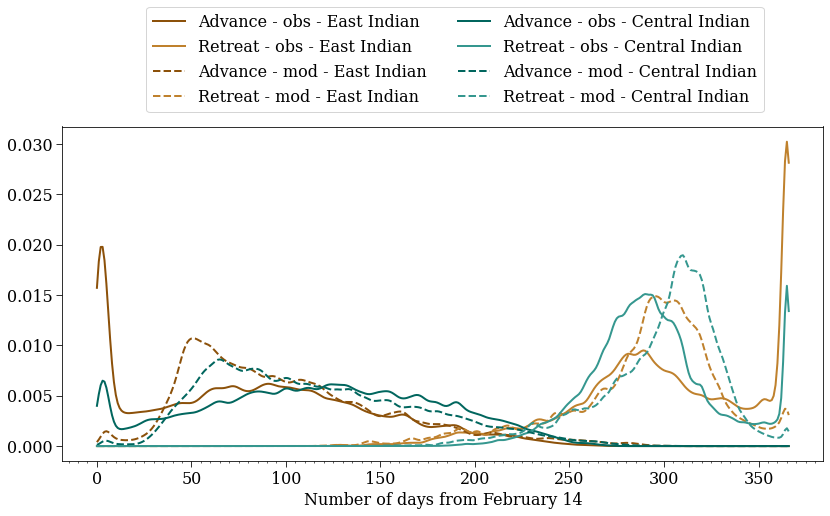

In [39]:
bins = np.arange(0, 367)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

#Initialising figure
fig = plt.figure(figsize = (17.5, 6))
ax = fig.add_subplot(111)

#Plotting data
ax.plot(bins, obs_EI['advance'], color = '#8c510a', linewidth = 2, 
        label = 'Advance - obs - East Indian')
ax.plot(bins, obs_EI['retreat'], color = '#bf812d', linewidth = 2, 
        label = 'Retreat - obs - East Indian')
ax.plot(bins, mod_EI['advance'], color = '#8c510a', 
        label = 'Advance - mod - East Indian', 
        linewidth = 2, linestyle = 'dashed')
ax.plot(bins, mod_EI['retreat'], color = '#bf812d', 
        label = 'Retreat - mod - East Indian', 
        linewidth = 2, linestyle = 'dashed')

ax.plot(bins, obs_CI['advance'], color = '#01665e', linewidth = 2, 
        label = 'Advance - obs - Central Indian')
ax.plot(bins, obs_CI['retreat'], color = '#35978f', linewidth = 2, 
        label = 'Retreat - obs - Central Indian')
ax.plot(bins, mod_CI['advance'], color = '#01665e', 
        label = 'Advance - mod - Central Indian', 
        linewidth = 2, linestyle = 'dashed')
ax.plot(bins, mod_CI['retreat'], color = '#35978f', 
        label = 'Retreat - mod - Central Indian', 
        linewidth = 2, linestyle = 'dashed')
#Increasing the size of the x and y axes ticks
ax.tick_params(length = 6)
# For the minor ticks, use no labels; five minor ticks to be included
#between each major tick pair 
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
ax.set_xlabel('Number of days from February 14')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.height * 0.8, box.width])

# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0.1, 1.02, 1, 0.2), ncol = 2)

plt.savefig('Indian_pdf.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

In [ ]:

fig = plt.figure(figsize = (17.5, 6))
ax = fig.add_subplot(111)
EI_w.plot(ax = ax, linewidth = 2, marker = 'o', markersize = 3.5, color = '#8c510a', label = 'Yearly weighted mean East Indian')
#Calculate the rolling decadal mean per sector and season
EI_w.rolling(time = 10, center = True).mean().dropna('time').plot(ax = ax, color = '#dfc27d', linestyle = '--', linewidth = 2,
                                                                  label = 'Rolling mean (10 years) East Indian')
plt.plot(EI_w.time, interceptEI+(slopeEI*EI_w.time.dt.year.values), 
         label = f'Trend line East Indian (p = {round(pEI, 3)})', color = '#bf812d', linewidth = 2)

CI_w.plot(ax = ax, linewidth = 2, marker = 'o', markersize = 3.5, color = '#01665e', label = 'Yearly weighted mean Central Indian')
CI_w.rolling(time = 10, center = True).mean().dropna('time').plot(ax = ax, color = '#80cdc1', linestyle = '--', linewidth = 2,
                                                                  label = 'Rolling mean (10 years) Central Indian')
plt.plot(CI_w.time, interceptCI+(slopeCI*CI_w.time.dt.year.values), 
         label = f'Trend line Central Indian (p = {round(pCI, 3)})', color = '#35978f', linewidth = 2)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.height * 0.8, box.width])

# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol = 2)

# #Remove x axis label
ax.set_xlabel('')
ax.set_ylabel('Days from February 15')
ax.set_title('')
# #Increasing the size of the x and y axes ticks
ax.tick_params(length = 6)
# For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
plt.savefig('Indian_year.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)